In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

panel = pd.read_pickle('../Data/returns_chars_panel.pkl') 
macro = pd.read_pickle('../Data/macro_timeseries.pkl')

In [5]:
# combine micro and macro data
df = pd.merge(panel,macro,on='date',how='left',suffixes=['','_macro']) 

# features + targets 
X = df.drop(columns=['ret','excess_ret','rfree','permno','date']) # everything except return info and IDs
y = df['excess_ret'] 

# Split Train Test 

In [19]:
# make 20 years of training data
date = df['date']
training = (date <= '1977-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values 

# make 10 years of validation data
validation = (date > '1977-03') & (date <= '1987-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

# make test data
test = (date > '1987-03') 
X_test, y_test = X.loc[test].values, y.loc[test].values 

# Finding baseline model for Neural Network 

## 2 layers 

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1680 - mse: 0.1577 - val_loss: 0.0393 - val_mse: 0.0298
Epoch 2/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0287 - mse: 0.0194 - val_loss: 0.0360 - val_mse: 0.0274
Epoch 3/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0267 - mse: 0.0184 - val_loss: 0.0344 - val_mse: 0.0271
Epoch 4/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0250 - mse: 0.0181 - val_loss: 0.0327 - val_mse: 0.0272
Epoch 5/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0231 - mse: 0.0180 - val_loss: 0.0311 - val_mse: 0.0274
Epoch 6/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0212 - mse: 0.0179 - val_loss: 0.0297 - val_mse: 0.0274
Epoch 7/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0198 - mse: 0.0178 - val_loss: 0.0293 - val_mse: 0.0278
Epoch 8/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0190 - mse: 0.0176 - val_loss: 0.0297 - val_mse: 0.0286
Epoch 9/100
1188/1188 ━━━━━━━━━━

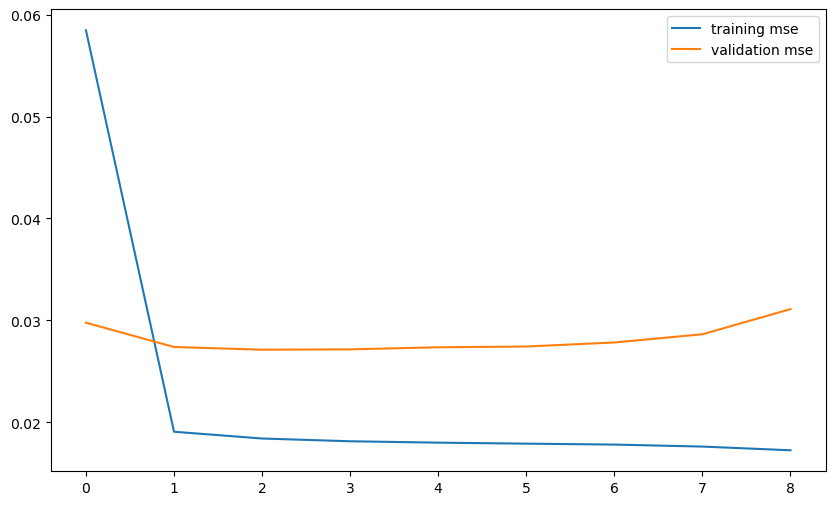

In [31]:
# Batch normalization hugely improves the performance
import tensorflow as tf
tf.random.set_seed(999)
from tensorflow.keras.models import Sequential
# Dense is the fully connected layer 
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import EarlyStopping

# hypers
batch_size = 512
learning_rate = 1e-4
lamda = 1e-5
patience = 2

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = L1(lamda), kernel_initializer = 'he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = L1(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='linear', kernel_regularizer = L1(lamda), kernel_initializer = 'he_normal')
    ])
    return model 

model = create_model()
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=True,
                    validation_data = (X_val, y_val),
                    # Defined the callback to see if the validation result actually improves 
                    callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])

fig, ax = plt.subplots(figsize=(10,6))
pd.Series(history.history['mse']).plot(ax=ax, label='training mse')
pd.Series(history.history['val_mse']).plot(ax=ax, label='validation mse')
ax.legend()